In [1]:
import pandas as pd
from dask import threaded, delayed
import sys
import time
import string

In [2]:
load_ext cython

In [3]:
sys.path.append('/Users/pradap/Documents/Research/Python-Package/scaling/dmagellan/')

In [4]:
from dmagellan.core.stringcontainer import StringContainer
from dmagellan.core.tokencontainer import TokenContainer
from dmagellan.core.invertedindex import InvertedIndex
from dmagellan.core.prober import Prober

In [5]:
def get_str_cols(dataframe):
    return dataframe.columns[dataframe.dtypes == 'object']

def str2bytes(x):
    if isinstance(x, bytes):
        return x
    else:
        return x.encode('utf-8')

In [6]:
@delayed
def postprocess(list_probe_result):
    ltbl_indices = list_probe_result[0].get_ltable_indices()
    rtbl_indices = list_probe_result[0].get_rtable_indices()
    return [ltbl_indices, rtbl_indices]


@delayed
def probe(tokens, invindex, y):
    probe_obj = Prober()
    probe_obj.probe(tokens, invindex, y)
    return probe_obj

@delayed
def build_inv_index(tokens):
    inv_obj = InvertedIndex()
    inv_obj.build_inv_index(tokens)
    return inv_obj

@delayed
def tokenize_strings(concat_strings, stopwords):
    n = concat_strings.get_size()
    tok_container_obj = TokenContainer()
    tok_container_obj.tokenize(concat_strings, stopwords)
    return tok_container_obj


@delayed
def preprocess_table(dataframe):
    str_cols = get_str_cols(dataframe)
    proj_df = dataframe[str_cols]
    concat_strings = []
    str_container = StringContainer()
    for row in proj_df.itertuples(name=None):
        idx = row[0]
        column_values = row[1:]
        strs = [column_value.strip() for column_value in column_values if not pd.isnull(column_value)]
        joined_row = ' '.join(strs)
        joined_row = joined_row.translate(None, string.punctuation)
        concat_strings.append(joined_row.lower())
        str_container.push_back(idx, str2bytes(joined_row.lower()))
    return str_container

In [7]:
# %%cython
# #distutils: language=c++
# import pandas as pd
# import numpy as np
# from libcpp.vector cimport vector
# from libcpp.string cimport string
# from libcpp.pair cimport pair
# from libcpp cimport bool
# from libcpp.set cimport set as oset
# from libcpp.map cimport map as omap
# from cython.parallel cimport prange
# from libcpp.algorithm cimport sort
# from dmagellan.core.stringcontainer cimport StringContainer
# # from dmagellan.core.stringcontainer import StringContainer
# from dmagellan.core.tokencontainer import TokenContainer
# from dmagellan.core.invertedindex import InvertedIndex
# from dmagellan.core.prober import Prober
# import string as pstring
# def get_str_cols(dataframe):
#     return dataframe.columns[dataframe.dtypes == 'object']

# def str2bytes(x):
#     if isinstance(x, bytes):
#         return x
#     else:
#         return x.encode('utf-8')
# def preprocess_table(dataframe):
#     str_cols = get_str_cols(dataframe)
#     proj_df = dataframe[str_cols]
#     concat_strings = []
#     str_container = StringContainer()
#     for row in proj_df.itertuples(name=None):
#         idx = row[0]
#         column_values = row[1:]
#         strs = [column_value.strip() for column_value in column_values if not pd.isnull(column_value)]
#         joined_row = ' '.join(strs)
#         joined_row = joined_row.translate(None, pstring.punctuation)
#         concat_strings.append(joined_row.lower())
#         str_container.push_back(idx, str2bytes(joined_row.lower()))
#     return str_container

# cdef int split_strings(StringContainer obj):
#     cdef vector[pair[int, string]] values
#     values = obj._get()
#     yy = np.array_split(values, 3)
#     return yy.size()
# def dummy(lstrings):
#     x = split_strings(lstrings)
#     print(x)
# A = pd.read_csv('person_table_A.csv')
# lstrings = preprocess_table(A)
# dummy(lstrings)


In [8]:
x = range(100)

In [9]:
import numpy as np

In [10]:
from distributed import Client

In [11]:
from dask import multiprocessing

In [12]:
import numpy as np
def downsample(ltable, rtable, sample_size, y_param, stopwords=[], n_lchunks=1,
            n_rchunks=4, scheduler=threaded.get, ret_delayed=False):

    #preprocess ltable
    st = time.time()
    lcat_strings = preprocess_table(ltable)
    print('preprocess_ltable: {0}'.format(time.time()-st))

    st = time.time()
    ltokens =  tokenize_strings(lcat_strings, stopwords)
    print('tokenize_ltable: {0}'.format(time.time()-st))

    st = time.time()
    invindex = build_inv_index(ltokens)
    print('build_inv_index: {0}'.format(time.time()-st))

    #preprocess rtable

    rsample = rtable.sample(sample_size, replace=False)
    rsplitted = np.array_split(rsample, n_rchunks)
    
    probe_results = []
    for i in range(n_rchunks):
        rcat_strings = preprocess_table(rsplitted[i])
        rtokens = tokenize_strings(rcat_strings, stopwords)
        probe_result = probe(rtokens, invindex, y_param)
        probe_results.append(probe_result)
    
    

    result = postprocess(probe_results)

    if ret_delayed == False:
        return result.compute()
    else:
        return result
    

In [13]:
A = pd.read_csv('tracks.csv')
B = pd.read_csv('songs.csv')

/Users/pradap/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
res = downsample(A, B, 10000, 1, ret_delayed=True)

preprocess_ltable: 0.000229120254517
tokenize_ltable: 0.000171184539795
build_inv_index: 8.29696655273e-05


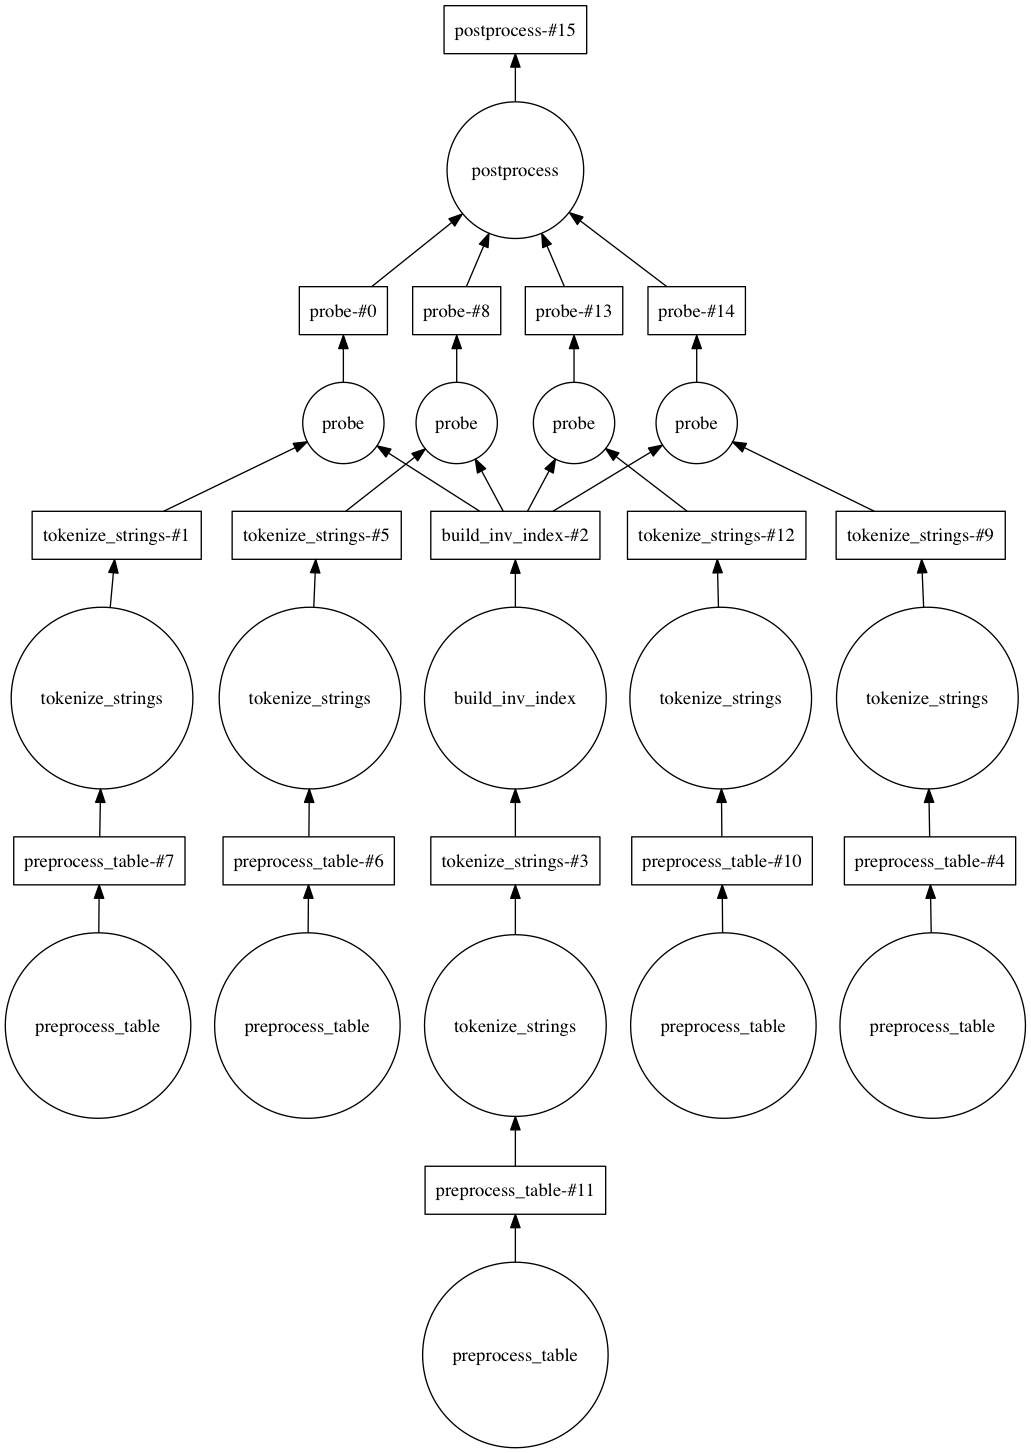

In [ ]:
res.visualize()

In [ ]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    values = res.compute(get=threaded.get)

[###########################             ] | 68% Completed | 18.4s